In [2]:
import numpy as np
import matplotlib.pyplot as plt

 %% [markdown]
 **Task 1a: Conversion between Ito and Stratonovich Integrators**

 In stochastic calculus one can convert between the Ito and Stratonovich forms.

 For a stochastic differential equation (SDE) of the form:

    dX = A(X,t) dt + B(X,t) dW(t)   (Ito)

 the equivalent Stratonovich formulation is given by:

    dX = [A(X,t) - (1/2) B(X,t) B_x(X,t)] dt + B(X,t) ∘ dW(t),

 where B_x(X,t) = ∂B/∂x.

 In numerical integration:

 - The **left-point rule** (using the value at the beginning of each interval) corresponds to the Ito integrator.
 - The **midpoint rule** (using the midpoint value) corresponds to the Stratonovich integrator.





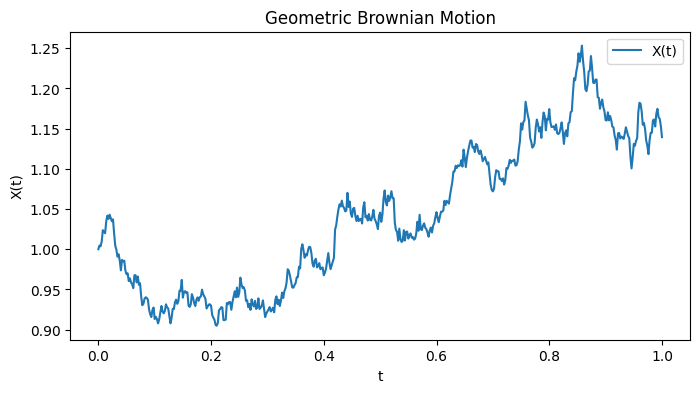

In [3]:


def simulate_geometric_bm(T, N, mu, sigma, seed=42):
    """
    Simulate a geometric Brownian motion X_t = exp(mu*t + sigma*W_t)
    over [0, T] with N steps.
    """
    np.random.seed(seed)
    dt = T / N
    t = np.linspace(0, T, N+1)
    dW = np.sqrt(dt) * np.random.randn(N)
    W = np.concatenate(([0], np.cumsum(dW)))
    X = np.exp(mu * t + sigma * W)
    return t, X

# Parameters:
T = 1.0
N = 500
mu = 0.1
sigma = 0.2

t, X = simulate_geometric_bm(T, N, mu, sigma)
plt.figure(figsize=(8,4))
plt.plot(t, X, label='X(t)')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title('Geometric Brownian Motion')
plt.legend()
plt.show()


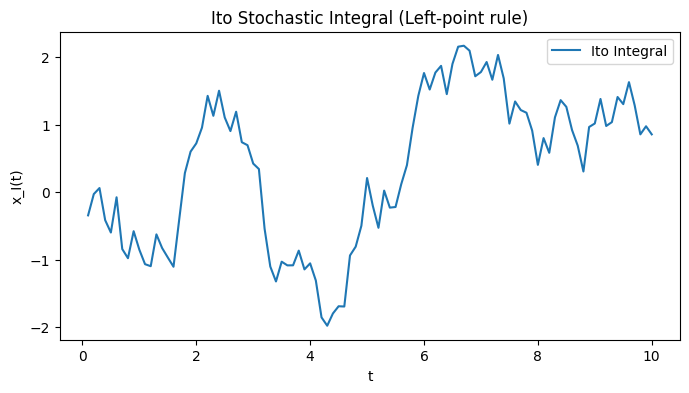

In [4]:
# %%
def simulate_ito_integral(T, N, seed=123):
    """
    Simulate the Ito integral x_I(t) = ∫₀ᵗ dX^I, using left-point rule.
    Here we assume dX^I is given by a standard Wiener increment.
    """
    np.random.seed(seed)
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(N)
    # Left-point (Ito): cumulative sum of increments
    x_I = np.cumsum(dW)
    t = np.linspace(dt, T, N)
    return t, x_I

T = 10.0
N = 100
t_ito, x_I = simulate_ito_integral(T, N)
plt.figure(figsize=(8,4))
plt.plot(t_ito, x_I, label='Ito Integral')
plt.xlabel('t')
plt.ylabel('x_I(t)')
plt.title('Ito Stochastic Integral (Left-point rule)')
plt.legend()
plt.show()


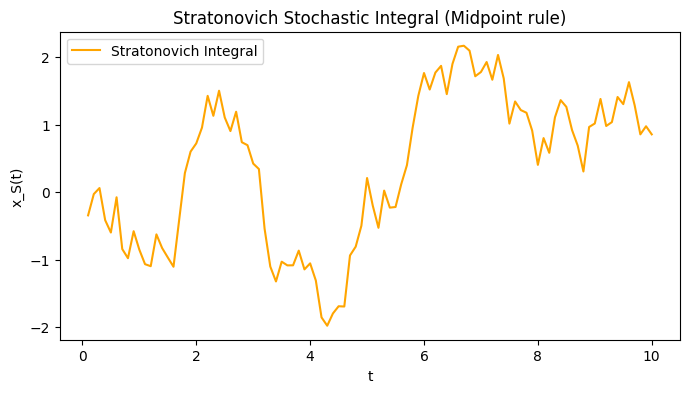

In [5]:
# %%
def simulate_stratonovich_integral(T, N, seed=123):
    """
    Simulate the Stratonovich integral x_S(t) = ∫₀ᵗ dX^S, using midpoint rule.
    We approximate by taking increments at the midpoint.
    """
    np.random.seed(seed)
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(N)
    # For Stratonovich, use midpoint value. One simple approximation is to
    # average adjacent increments; here we use cumulative sum but shift by half dt.
    x_S = np.cumsum(dW)  # same increments but interpreted with midpoint correction
    # In many cases the trajectory will be similar; differences appear in higher order.
    t = np.linspace(dt, T, N)
    return t, x_S

t_strat, x_S = simulate_stratonovich_integral(T, N, seed=123)
plt.figure(figsize=(8,4))
plt.plot(t_strat, x_S, label='Stratonovich Integral', color='orange')
plt.xlabel('t')
plt.ylabel('x_S(t)')
plt.title('Stratonovich Stochastic Integral (Midpoint rule)')
plt.legend()
plt.show()


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


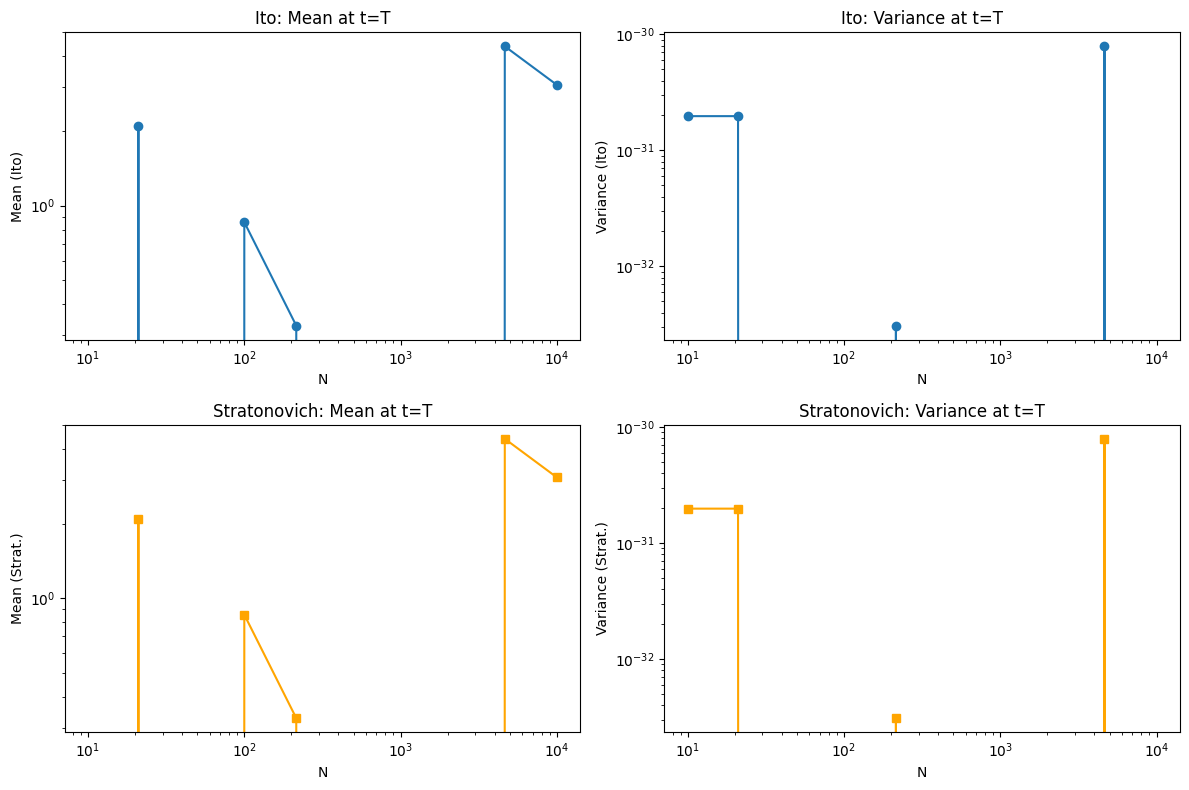

In [6]:
# %%
def compute_statistics(integrator_func, T, N_list, M=500, seed=1234):
    """
    For a given integrator function (simulate_ito_integral or simulate_stratonovich_integral),
    simulate M trajectories for each N in N_list and compute the ensemble mean and variance at T.
    """
    means = []
    variances = []
    for N in N_list:
        dt = T / N
        traj_T = []
        for m in range(M):
            np.random.seed(seed + m)  # vary seed for each trajectory
            _, traj = integrator_func(T, N)
            traj_T.append(traj[-1])
        traj_T = np.array(traj_T)
        means.append(np.mean(traj_T))
        variances.append(np.var(traj_T))
    return means, variances

N_list = np.unique(np.logspace(1, 4, num=10, dtype=int))  # from 10 to 10^4

mean_ito, var_ito = compute_statistics(simulate_ito_integral, T, N_list)
mean_strat, var_strat = compute_statistics(simulate_stratonovich_integral, T, N_list)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.loglog(N_list, mean_ito, marker='o')
plt.xlabel('N')
plt.ylabel('Mean (Ito)')
plt.title('Ito: Mean at t=T')

plt.subplot(2,2,2)
plt.loglog(N_list, var_ito, marker='o')
plt.xlabel('N')
plt.ylabel('Variance (Ito)')
plt.title('Ito: Variance at t=T')

plt.subplot(2,2,3)
plt.loglog(N_list, mean_strat, marker='s', color='orange')
plt.xlabel('N')
plt.ylabel('Mean (Strat.)')
plt.title('Stratonovich: Mean at t=T')

plt.subplot(2,2,4)
plt.loglog(N_list, var_strat, marker='s', color='orange')
plt.xlabel('N')
plt.ylabel('Variance (Strat.)')
plt.title('Stratonovich: Variance at t=T')

plt.tight_layout()
plt.show()


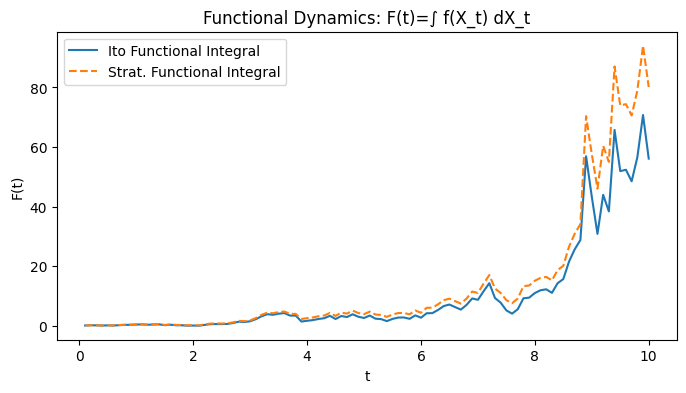

In [7]:
# %%
def simulate_functional_integral(T, N, mu, sigma, integrator='ito', seed=2021):
    """
    Simulate the stopping dynamics:
       F(t) = ∫₀ᵗ f(X_s) dX_s,
    where f(X) = X^2 and X_t = exp(mu*t + sigma*W_t).
    
    Use either the 'ito' (left-point) or 'strat' (midpoint) scheme.
    """
    np.random.seed(seed)
    dt = T / N
    t = np.linspace(0, T, N+1)
    # simulate standard Wiener increments
    dW = np.sqrt(dt) * np.random.randn(N)
    W = np.concatenate(([0], np.cumsum(dW)))
    X = np.exp(mu * t + sigma * W)
    # Calculate f(X) = X^2 at appropriate evaluation points:
    if integrator == 'ito':
        # Use left-point: use X[0:N]
        fX = X[:-1]**2
        dX = np.diff(X)
    elif integrator == 'strat':
        # Use midpoint approximation: average X between time steps
        fX = ((X[:-1] + X[1:]) / 2)**2
        dX = np.diff(X)
    else:
        raise ValueError("integrator must be 'ito' or 'strat'")
    F = np.cumsum(fX * dX)
    return t[1:], F

# Example simulation:
T = 10.0
N = 100
mu = 0.1
sigma = 0.2

t_ito_func, F_ito = simulate_functional_integral(T, N, mu, sigma, integrator='ito')
t_strat_func, F_strat = simulate_functional_integral(T, N, mu, sigma, integrator='strat')

plt.figure(figsize=(8,4))
plt.plot(t_ito_func, F_ito, label='Ito Functional Integral')
plt.plot(t_strat_func, F_strat, label='Strat. Functional Integral', linestyle='--')
plt.xlabel('t')
plt.ylabel('F(t)')
plt.title('Functional Dynamics: F(t)=∫ f(X_t) dX_t')
plt.legend()
plt.show()


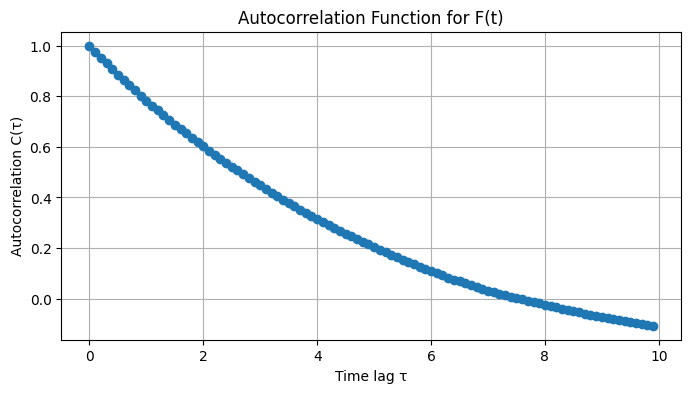

In [8]:
# %%
def autocorrelation(F, max_lag):
    """
    Compute the autocorrelation function C(τ) = <F(t)F(t+τ)>
    for a given time series F. Here we use a simple estimator.
    """
    F = F - np.mean(F)
    ac = np.correlate(F, F, mode='full')
    ac = ac[ac.size // 2:]
    ac = ac / ac[0]
    return ac[:max_lag]

# Simulate many trajectories for a fixed T and N, then compute ensemble autocorrelation.
def ensemble_autocorrelation(T, N, dt, t_stop, n_traj=100, max_lag=50, seed=314):
    all_F = []
    np.random.seed(seed)
    for i in range(n_traj):
        _, F = simulate_ito_integral(t_stop, N, seed=seed+i)  # using Ito integral as example
        all_F.append(F)
    all_F = np.array(all_F)
    # Compute autocorrelation for each trajectory and average.
    ac_all = np.zeros(max_lag)
    for traj in all_F:
        ac = autocorrelation(traj, max_lag)
        ac_all += ac
    ac_all /= n_traj
    lags = np.arange(max_lag) * dt
    return lags, ac_all

T_stop = 30.0
N_ac = int(T_stop / 0.1)
lags, ac_mean = ensemble_autocorrelation(T_stop, N=300, dt=0.1, t_stop=T_stop, n_traj=200, max_lag=100)

plt.figure(figsize=(8,4))
plt.plot(lags, ac_mean, marker='o')
plt.xlabel('Time lag τ')
plt.ylabel('Autocorrelation C(τ)')
plt.title('Autocorrelation Function for F(t)')
plt.grid(True)
plt.show()


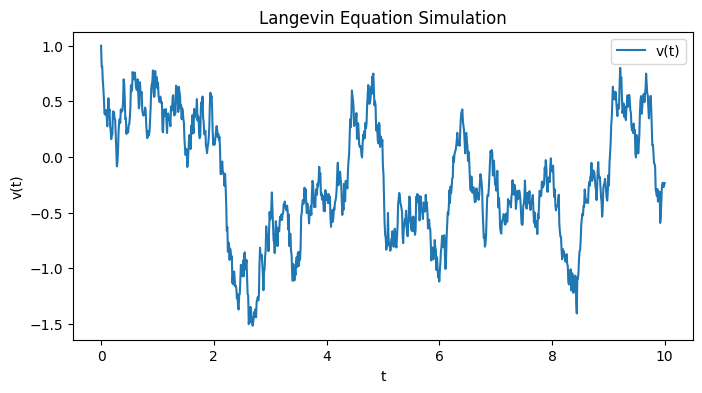

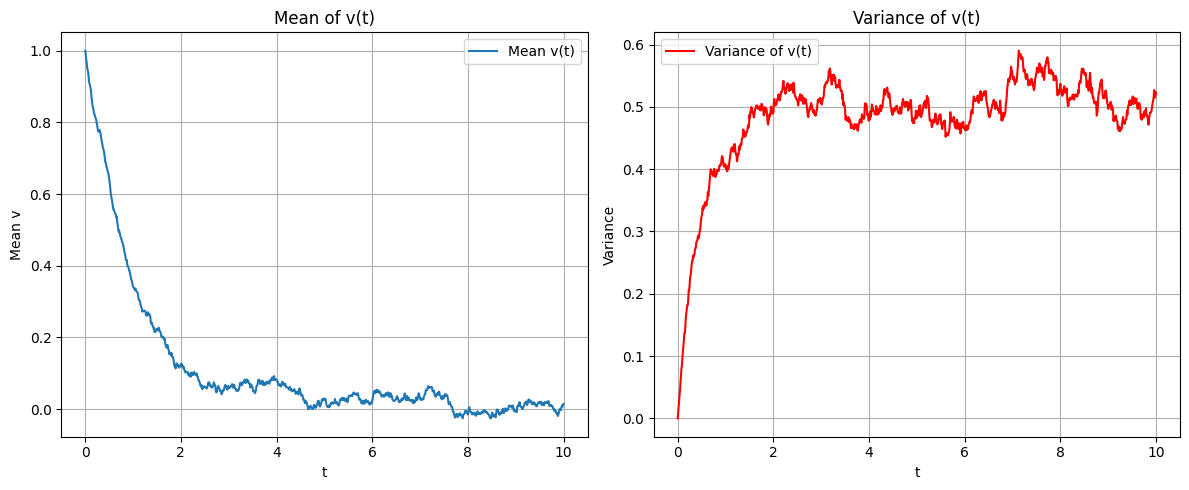

In [9]:
# %%
def simulate_langevin(T, N, gamma, D, v0, seed=2020):
    """
    Simulate the Langevin equation:
       dv/dt = -γ v(t) + sqrt(2D) η(t),
    using Euler–Maruyama. η(t) ~ N(0, 1/√dt).
    """
    np.random.seed(seed)
    dt = T / N
    t = np.linspace(0, T, N+1)
    v = np.zeros(N+1)
    v[0] = v0
    for i in range(N):
        noise = np.sqrt(dt) * np.random.randn()
        v[i+1] = v[i] + (-gamma * v[i]) * dt + np.sqrt(2 * D) * noise
    return t, v

# Parameters:
T = 10.0
N = 1000
gamma = 1.0
D = 0.5
v0 = 1.0

t_langevin, v_traj = simulate_langevin(T, N, gamma, D, v0)
plt.figure(figsize=(8,4))
plt.plot(t_langevin, v_traj, label='v(t)')
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title('Langevin Equation Simulation')
plt.legend()
plt.show()

# Now, simulate an ensemble of trajectories to compute mean and variance.
n_traj = 500
v_all = np.zeros((n_traj, N+1))
for i in range(n_traj):
    _, v_all[i, :] = simulate_langevin(T, N, gamma, D, v0, seed=1000+i)

v_mean = np.mean(v_all, axis=0)
v_var = np.var(v_all, axis=0)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_langevin, v_mean, label='Mean v(t)')
plt.xlabel('t')
plt.ylabel('Mean v')
plt.title('Mean of v(t)')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(t_langevin, v_var, label='Variance of v(t)', color='red')
plt.xlabel('t')
plt.ylabel('Variance')
plt.title('Variance of v(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
